# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:31:33.612873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:31:33.612929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:31:33.614376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-11, who has ID: A2RYWPOL4NN2KG

In [2]:
parameters = {}

user = "users-11"
user_id = "A2RYWPOL4NN2KG"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,ASCKM9DC34HIM,B00005Q7CJ,B00WPZ63Q8,B00004T2WR
1,ASCKM9DC34HIM,B00004T2WR,B000795XMY,B00WPZ63Q8
2,ASCKM9DC34HIM,B007XXLTDO,B0010B6IFY,B00IOTB7PG
3,ASCKM9DC34HIM,B00J80SCU8,B007XXLTDO,B00D6FFQTQ
4,A27IFVQPES35EH,B00004T2WR,B002AV3NGA,B00993PMIO
...,...,...,...,...
20717,A13WIDE28O6KGG,B01H4Y4V5O,B0012KB466,B01F4TJFLQ
20718,A2UNP24IXP902N,B01H4Y4V5O,B00025Z6W0,B0002DJ9T8
20719,ATLZKDORVRRM8,B01H4Y50CC,B00115QA2A,B00YDS34HG
20720,A27UCU6Y2I6527,B01H4Y50CC,B0177J0FFQ,B01CCJBV9U


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 20722
Number of sequences and targets after removal: 20385


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A2RYWPOL4NN2KG
productID                 B01CJFQA3O
purchased_before_1        B0006342P0
purchased_before_2        B0178KDXQW
Name: 505, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 20384
Number of sequences and targets after dropping duplicates: 18877


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 149
Number of unique product IDs in sequences: 13318


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B00WPZ63Q8', 'B00004T2WR'],
        ['B000795XMY', 'B00WPZ63Q8'],
        ['B0010B6IFY', 'B00IOTB7PG'],
        ['B007XXLTDO', 'B00D6FFQTQ'],
        ['B002AV3NGA', 'B00993PMIO'],
        ['B000IW71BQ', 'B00004T2WR'],
        ['B002ZUZXUU', 'B000IW71BQ'],
        ['B00004T2WR', 'B00005Q7CJ'],
        ['B00005Q7CJ', 'B007XXLTDO'],
        ['B00OIOB90E', 'B00IEDA5S2']], dtype=object),
 array(['B00005Q7CJ', 'B00004T2WR', 'B007XXLTDO', 'B00J80SCU8',
        'B00004T2WR', 'B00005Q7CJ', 'B00004T2WR', 'B007XXLTDO',
        'B00J80SCU8', 'B00005Q7CJ'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[115946, 148],
        [8761, 115946],
        [19483, 89471],
        [57476, 74928],
        [29987, 61862],
        [13544, 148],
        [32270, 13544],
        [148, 173],
        [173, 57476],
        [103908, 88535]], dtype=object),
 array([173, 148, 57476, 90619, 148, 173, 148, 57476, 90619, 173],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 15091
Number of validation sequences: 1892
Number of test sequences: 1894

Number of train targets: 15091
Number of validation targets: 1892
Number of test targets: 1894

Number of classes (unique product IDs) in the train targets: 145
Number of classes in the validation targets: 147
Number of classes in the test targets: 149


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([90619, 140385], dtype=object),
 array([17222, 17222], dtype=object),
 array([19918, 19918], dtype=object),
 array([39379, 109448], dtype=object),
 array([29987, 61862], dtype=object),
 array([34770, 44577], dtype=object),
 array([81302, 90619], dtype=object),
 array([55346, 55345], dtype=object),
 array([129725, 109155], dtype=object),
 array([90619, 173], dtype=object)]

In [19]:
y_train[:10]

[148, 148, 148, 148, 148, 148, 148, 148, 148, 148]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/472 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0796 - f1_score: 0.0497 - f1_score_at_k: 0.1025 - hit_rate_at_k: 0.2372 - loss: 11.8362 - ndcg_at_k: 0.0544            

I0000 00:00:1714591908.312876    3038 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


472/472 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.0953 - f1_score: 0.0377 - f1_score_at_k: 0.0822 - hit_rate_at_k: 0.3462 - loss: 8.5246 - ndcg_at_k: 0.0746 - val_accuracy: 0.0973 - val_f1_score: 0.0991 - val_f1_score_at_k: 0.3292 - val_hit_rate_at_k: 0.3411 - val_loss: 4.1922 - val_ndcg_at_k: 0.0734
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1431 - f1_score: 0.0807 - f1_score_at_k: 0.1199 - hit_rate_at_k: 0.4186 - loss: 3.7622 - ndcg_at_k: 0.0957 - val_accuracy: 0.1480 - val_f1_score: 0.1841 - val_f1_score_at_k: 0.3782 - val_hit_rate_at_k: 0.3750 - val_loss: 3.8965 - val_ndcg_at_k: 0.0893
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1906 - f1_score: 0.1357 - f1_score_at_k: 0.1644 - hit_rate_at_k: 0.4593 - loss: 3.4350 - ndcg_at_k: 0.1118 - val_accuracy: 0.1818 - val_f1_score: 0.2333 - val_f1_score_at_k: 0.4112 - val_hit_rate_at_k: 0.3865 - val_loss: 3.8458 - val_ndcg_at_k: 0.0974
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - a

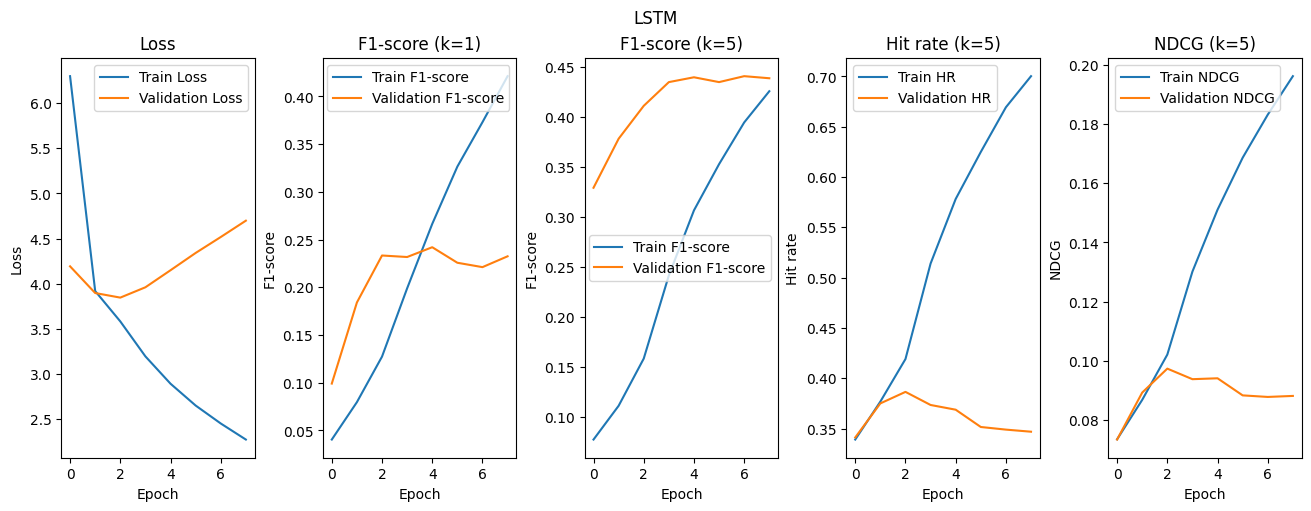

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2301 - f1_score: 0.3155 - f1_score_at_k: 0.5459 - hit_rate_at_k: 0.4440 - loss: 3.9808 - ndcg_at_k: 0.1164
Test loss: 4.6052
Test accuracy: 0.1716
Test F1@1: 0.2388
Test F1@5: 0.4342
Test HR@5: 0.3396
Test NDCG@5: 0.0871


In [32]:
parameters

{'user': 'users-11',
 'user_id': 'A2RYWPOL4NN2KG',
 'number_of_sequences_and_targets_before_removal': 20722,
 'number_of_sequences_and_targets_after_removal': 20385,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 18877,
 'num_unique_product_ids_in_targets': 149,
 'num_unique_product_ids_in_sequences': 13318,
 'number_of_sequences_and_targets_train': 15091,
 'number_of_sequences_and_targets_validation': 1892,
 'number_of_sequences_and_targets_test': 1894,
 'number_of_unique_products_in_targets_train': 145,
 'number_of_unique_products_in_targets_validation': 147,
 'number_of_unique_products_in_targets_test': 149,
 'model_lstm_test_loss': 4.605166912078857,
 'model_lstm_test_accuracy': 0.1716,
 'model_lstm_test_f1_score_k_1': 0.2388,
 'model_lstm_test_f1_score_k_5': 0.4342,
 'model_lstm_test_hr': 0.3396,
 'model_lstm_test_ndcg': 0.0871}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.0971 - f1_score: 0.0458 - f1_score_at_k: 0.0843 - hit_rate_at_k: 0.3625 - loss: 8.1352 - ndcg_at_k: 0.0777 - val_accuracy: 0.0951 - val_f1_score: 0.0940 - val_f1_score_at_k: 0.3352 - val_hit_rate_at_k: 0.3432 - val_loss: 4.1657 - val_ndcg_at_k: 0.0745
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1517 - f1_score: 0.0989 - f1_score_at_k: 0.1271 - hit_rate_at_k: 0.4257 - loss: 3.6791 - ndcg_at_k: 0.0984 - val_accuracy: 0.1744 - val_f1_score: 0.1980 - val_f1_score_at_k: 0.3991 - val_hit_rate_at_k: 0.3776 - val_loss: 3.8325 - val_ndcg_at_k: 0.0943
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2346 - f1_score: 0.1805 - f1_score_at_k: 0.2166 - hit_rate_at_k: 0.5147 - loss: 3.2085 - ndcg_at_k: 0.1282 - val_accuracy: 0.1839 - val_f1_score: 0.2332 - val_f1_score_at_k: 0.4322 - val_hit_rate_at_k: 0.3891 - val_loss: 3.8342 - val_ndcg_at_k: 0.0977
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7

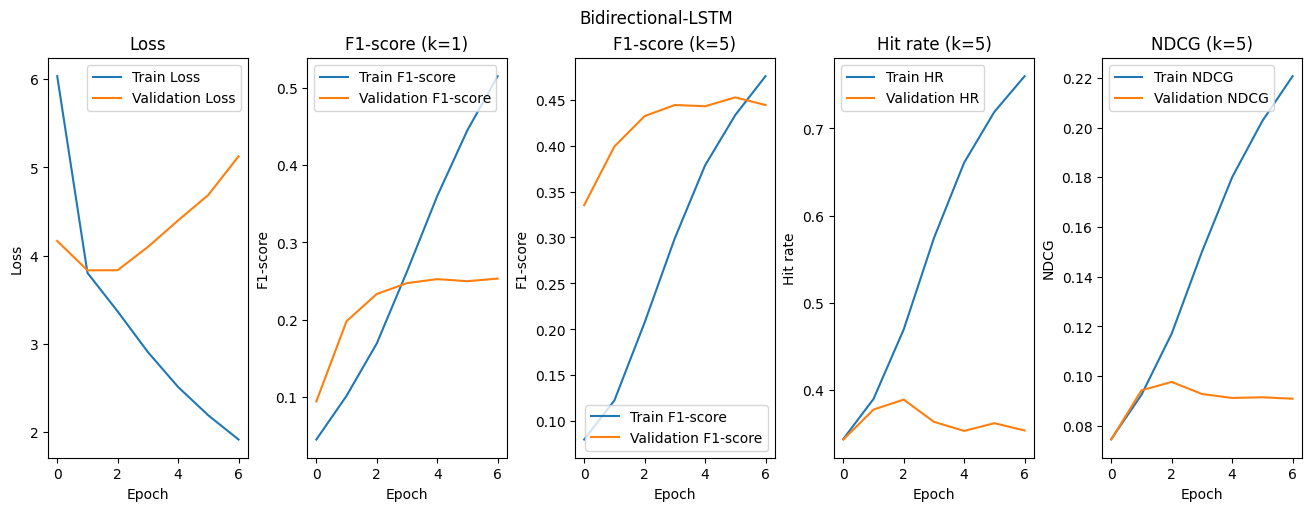

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2279 - f1_score: 0.3075 - f1_score_at_k: 0.5389 - hit_rate_at_k: 0.4343 - loss: 4.4694 - ndcg_at_k: 0.1133
Test loss: 5.095
Test accuracy: 0.1711
Test F1@1: 0.2346
Test F1@5: 0.4482
Test HR@5: 0.3517
Test NDCG@5: 0.0889


In [37]:
parameters

{'user': 'users-11',
 'user_id': 'A2RYWPOL4NN2KG',
 'number_of_sequences_and_targets_before_removal': 20722,
 'number_of_sequences_and_targets_after_removal': 20385,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 18877,
 'num_unique_product_ids_in_targets': 149,
 'num_unique_product_ids_in_sequences': 13318,
 'number_of_sequences_and_targets_train': 15091,
 'number_of_sequences_and_targets_validation': 1892,
 'number_of_sequences_and_targets_test': 1894,
 'number_of_unique_products_in_targets_train': 145,
 'number_of_unique_products_in_targets_validation': 147,
 'number_of_unique_products_in_targets_test': 149,
 'model_lstm_test_loss': 4.605166912078857,
 'model_lstm_test_accuracy': 0.1716,
 'model_lstm_test_f1_score_k_1': 0.2388,
 'model_lstm_test_f1_score_k_5': 0.4342,
 'model_lstm_test_hr': 0.3396,
 'model_lstm_test_ndcg': 0.0871,
 'model_bi_lstm_test_loss': 5.095020294189453,
 'model_bi_lstm_test_accuracy': 0.1711,
 'model_bi_lstm_test_f1_score_k_1': 0

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.0856 - f1_score: 0.0345 - f1_score_at_k: 0.0744 - hit_rate_at_k: 0.3470 - loss: 8.5424 - ndcg_at_k: 0.0728 - val_accuracy: 0.1015 - val_f1_score: 0.1047 - val_f1_score_at_k: 0.3455 - val_hit_rate_at_k: 0.3615 - val_loss: 4.1632 - val_ndcg_at_k: 0.0777
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1286 - f1_score: 0.0672 - f1_score_at_k: 0.1135 - hit_rate_at_k: 0.4119 - loss: 3.7836 - ndcg_at_k: 0.0920 - val_accuracy: 0.1543 - val_f1_score: 0.1790 - val_f1_score_at_k: 0.3635 - val_hit_rate_at_k: 0.3661 - val_loss: 3.9001 - val_ndcg_at_k: 0.0878
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1837 - f1_score: 0.1278 - f1_score_at_k: 0.1488 - hit_rate_at_k: 0.4505 - loss: 3.5078 - ndcg_at_k: 0.1083 - val_accuracy: 0.1607 - val_f1_score: 0.1937 - val_f1_score_at_k: 0.4117 - val_hit_rate_at_k: 0.3807 - val_loss: 3.8596 - val_ndcg_at_k: 0.0919
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 6

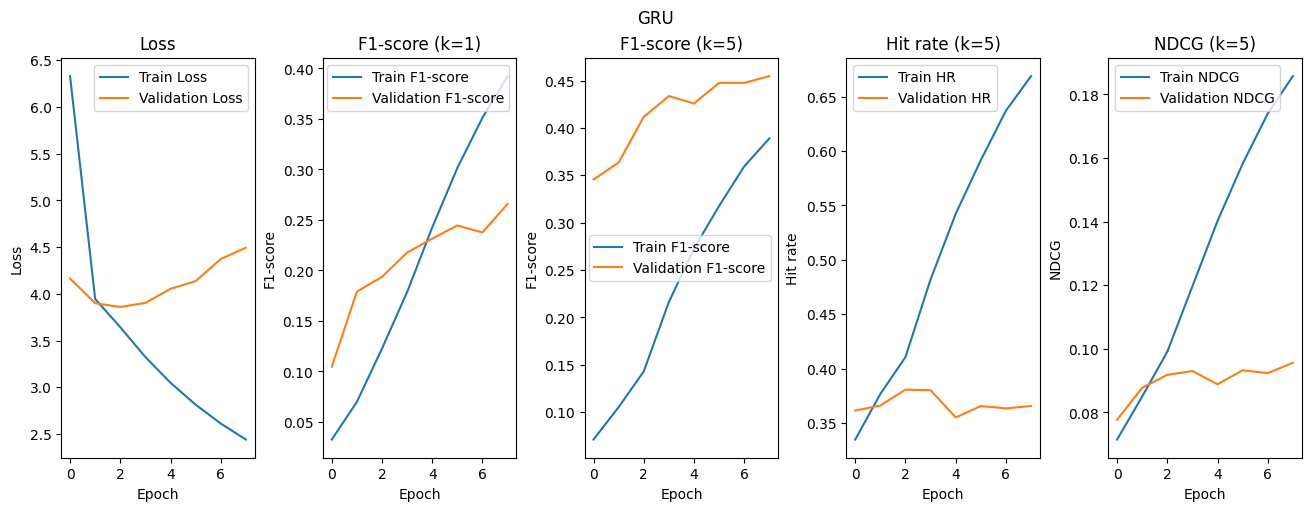

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2322 - f1_score: 0.3206 - f1_score_at_k: 0.5276 - hit_rate_at_k: 0.4346 - loss: 3.9151 - ndcg_at_k: 0.1141
Test loss: 4.503
Test accuracy: 0.1727
Test F1@1: 0.2424
Test F1@5: 0.4252
Test HR@5: 0.3398
Test NDCG@5: 0.0873


In [42]:
parameters

{'user': 'users-11',
 'user_id': 'A2RYWPOL4NN2KG',
 'number_of_sequences_and_targets_before_removal': 20722,
 'number_of_sequences_and_targets_after_removal': 20385,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 18877,
 'num_unique_product_ids_in_targets': 149,
 'num_unique_product_ids_in_sequences': 13318,
 'number_of_sequences_and_targets_train': 15091,
 'number_of_sequences_and_targets_validation': 1892,
 'number_of_sequences_and_targets_test': 1894,
 'number_of_unique_products_in_targets_train': 145,
 'number_of_unique_products_in_targets_validation': 147,
 'number_of_unique_products_in_targets_test': 149,
 'model_lstm_test_loss': 4.605166912078857,
 'model_lstm_test_accuracy': 0.1716,
 'model_lstm_test_f1_score_k_1': 0.2388,
 'model_lstm_test_f1_score_k_5': 0.4342,
 'model_lstm_test_hr': 0.3396,
 'model_lstm_test_ndcg': 0.0871,
 'model_bi_lstm_test_loss': 5.095020294189453,
 'model_bi_lstm_test_accuracy': 0.1711,
 'model_bi_lstm_test_f1_score_k_1': 0

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.0541 - f1_score: 0.0417 - f1_score_at_k: 0.0817 - hit_rate_at_k: 0.1793 - loss: 10.2340 - ndcg_at_k: 0.0397 - val_accuracy: 0.1168 - val_f1_score: 0.1206 - val_f1_score_at_k: 0.3544 - val_hit_rate_at_k: 0.3693 - val_loss: 4.0767 - val_ndcg_at_k: 0.0818
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1301 - f1_score: 0.0802 - f1_score_at_k: 0.1226 - hit_rate_at_k: 0.4273 - loss: 3.8407 - ndcg_at_k: 0.0946 - val_accuracy: 0.1475 - val_f1_score: 0.1696 - val_f1_score_at_k: 0.3699 - val_hit_rate_at_k: 0.3781 - val_loss: 3.9276 - val_ndcg_at_k: 0.0885
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1494 - f1_score: 0.0982 - f1_score_at_k: 0.1339 - hit_rate_at_k: 0.4365 - loss: 3.7297 - ndcg_at_k: 0.1003 - val_accuracy: 0.1527 - val_f1_score: 0.1876 - val_f1_score_at_k: 0.3814 - val_hit_rate_at_k: 0.3828 - val_loss: 3.8783 - val_ndcg_at_k: 0.0912
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 

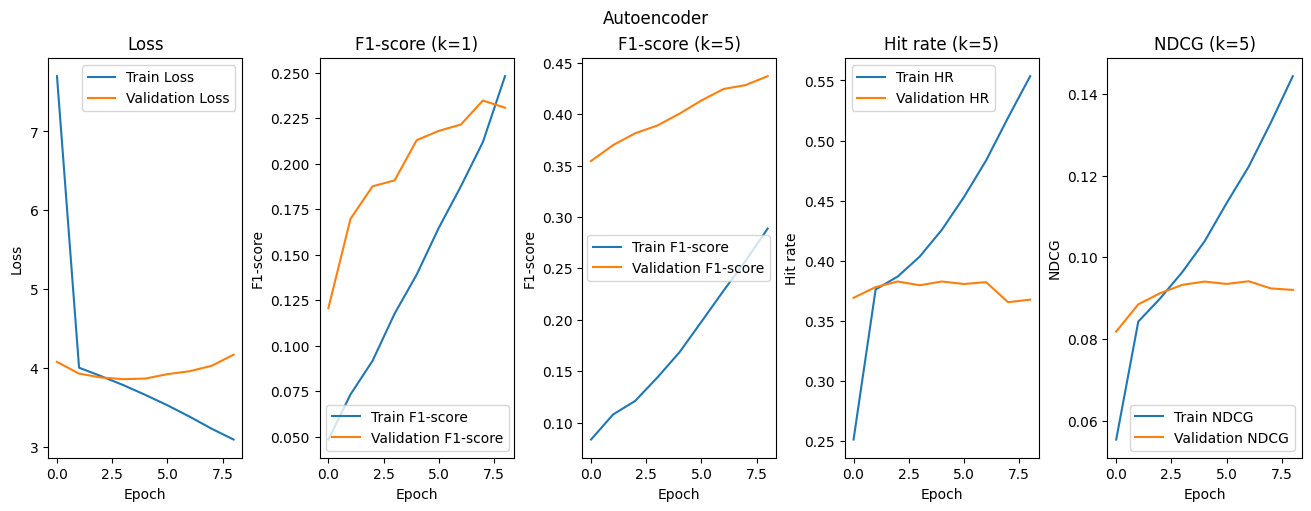

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2690 - f1_score: 0.3445 - f1_score_at_k: 0.5370 - hit_rate_at_k: 0.4630 - loss: 3.6251 - ndcg_at_k: 0.1251
Test loss: 4.2133
Test accuracy: 0.1785
Test F1@1: 0.237
Test F1@5: 0.4226
Test HR@5: 0.351
Test NDCG@5: 0.0896


In [47]:
parameters

{'user': 'users-11',
 'user_id': 'A2RYWPOL4NN2KG',
 'number_of_sequences_and_targets_before_removal': 20722,
 'number_of_sequences_and_targets_after_removal': 20385,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 18877,
 'num_unique_product_ids_in_targets': 149,
 'num_unique_product_ids_in_sequences': 13318,
 'number_of_sequences_and_targets_train': 15091,
 'number_of_sequences_and_targets_validation': 1892,
 'number_of_sequences_and_targets_test': 1894,
 'number_of_unique_products_in_targets_train': 145,
 'number_of_unique_products_in_targets_validation': 147,
 'number_of_unique_products_in_targets_test': 149,
 'model_lstm_test_loss': 4.605166912078857,
 'model_lstm_test_accuracy': 0.1716,
 'model_lstm_test_f1_score_k_1': 0.2388,
 'model_lstm_test_f1_score_k_5': 0.4342,
 'model_lstm_test_hr': 0.3396,
 'model_lstm_test_ndcg': 0.0871,
 'model_bi_lstm_test_loss': 5.095020294189453,
 'model_bi_lstm_test_accuracy': 0.1711,
 'model_bi_lstm_test_f1_score_k_1': 0

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A2RYWPOL4NN2KG', 'sequence': [7098, 128531], 'target': 136096}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 1.0
NDCG@50: 0.014669273979961872
-------------
HT@100: 1.0
NDCG@100: 0.0090359291061759
-------------
HT@200: 1.0
NDCG@200: 0.005433971062302589
-------------
HT@300: 1.0
NDCG@300: 0.003993349615484476
-------------
HT@400: 1.0
NDCG@400: 0.0031953018624335527
-------------
HT@500: 1.0
NDCG@500: 0.0026815326418727636
-------------
